In [1]:
%load_ext nb_black
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
from scipy.stats import chi2_contingency
from scipy import stats

<IPython.core.display.Javascript object>

In [2]:
# x=pd.read_csv('../_xlable4_withNa_AllColumns.txt')
# y=pd.read_csv('../_targelable4_withNa_AllColumns.txt')

# y=y[['Unnamed: 0','S000501', ]]

<IPython.core.display.Javascript object>

In [3]:
# data= pd.merge(x,y, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
data = pd.read_csv("../../sep19SexAndAgeAddedFINAL DATASET_ver2.txt", sep=",")
data["max"] = np.min(data[["FIELD_6", "FIELD_7"]], axis=1)
data = data.drop(columns=["FIELD_6", "FIELD_7"])

<IPython.core.display.Javascript object>

In [4]:
# change field 38 to 3 group
condtion = [
    data.FIELD_38 == 0,
    (data.FIELD_38 > 0) & (data.FIELD_38 < 4),
    data.FIELD_38 >= 4,
]
choice = [0, 1, 2]
data["FIELD_38_C"] = np.select(condtion, choice, default=np.nan)

<IPython.core.display.Javascript object>

In [5]:
# add Class to the dataset
_class = []
for i in range(data.shape[0]):
    if (data.S000501[i] >= 140) | (data.S000502[i] >= 90):
        _class.append(2)
    elif (data.S000501[i] < 120) & (data.S000502[i] < 80):
        _class.append(0)
    else:
        _class.append(1)
data["CLASS"] = _class

<IPython.core.display.Javascript object>

In [6]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia
print(data.shape)

(466680, 407)


<IPython.core.display.Javascript object>

In [7]:
# split column types to categorical and numerical
numerical_cols = list(data.columns[~data.columns.str.startswith("FIELD")])
categorical_cols = list(data.columns[data.columns.str.startswith("FIELD")])
categorical_cols.append("CLASS")
numerical_cols.remove("SEX")
categorical_cols.append("SEX")

<IPython.core.display.Javascript object>

Calculate correlation Value - for numerical values
========

In [8]:
corr = data[numerical_cols].corr()
corr = corr.S000502
corrvalPD = pd.DataFrame()
corrvalPD["Col"] = corr.index
corrvalPD["val"] = abs(corr.values)

corrvalPD = corrvalPD.sort_values(by="val", ascending=False)
corrvalPD.head()

,Col,val
214,S000502,1.0
178,L518900,1.0
59,L117700,1.0
148,L501600,1.0
159,L503200,1.0


<IPython.core.display.Javascript object>

In [9]:
# count of none NA values of feature set
mydataset = data.copy()[numerical_cols]
colCount = []
for i in mydataset.columns:
    colCount.append([i, mydataset[i].dropna().shape[0]])

colCountPD = pd.DataFrame(colCount, columns=["Col", "Count"])
colCountPD.head()

,Col,Count
0,Unnamed: 0,466680
1,COMPARE,466680
2,AGE,466679
3,B_DAY,466679
4,L100100,446887


<IPython.core.display.Javascript object>

In [10]:
mergedColCorrCount = pd.merge(
    corrvalPD, colCountPD, how="inner", left_on="Col", right_on="Col"
)
mergedColCorrCount = mergedColCorrCount[mergedColCorrCount.Count > 50000]
mergedColCorrCount = mergedColCorrCount.sort_values(by="val", ascending=False)
mergedColCorrCount.head(20)

,Col,val,Count
0,S000502,1.000000,466410
12,S000501,0.772022,466410
16,CLASS,0.749195,466680
28,S000300,0.354385,465393
32,L190400,0.331420,466197
33,L190500,0.323375,465172
34,L190300,0.321483,465316
37,L100700,0.293079,447592
39,L103000,0.267757,465103
40,L103300,0.266663,397549


<IPython.core.display.Javascript object>

In [11]:
print(list(mergedColCorrCount.head(20).Col))

['S000502', 'S000501', 'CLASS', 'S000300', 'L190400', 'L190500', 'L190300', 'L100700', 'L103000', 'L103300', 'L100800', 'S000600', 'L101700', 'L100500', 'L101300', 'S000100', 'L102900', 'S010102', 'S010101', 'AGE']


<IPython.core.display.Javascript object>

Anova test - For categorical values [Questionnaire answers]
=======

In [12]:
mydataset = data.copy()[categorical_cols]  # [np.insert(categorical_cols,0,'L100800')]

# mydataset=mydataset.drop(columns=['FIELD_1','FIELD_2','FIELD_8','FIELD_10','FIELD_11','FIELD_12','FIELD_39','FIELD_88',
#                            'FIELD_89','FIELD_109','FIELD_110','FIELD_111','FIELD_70','FIELD_82','FIELD_85','FIELD_91',
#                            'FIELD_103','FIELD_106'])

# mydataset=mydataset.drop(columns=['FIELD_1','FIELD_2','FIELD_87','FIELD_8','FIELD_10','FIELD_11','FIELD_12','FIELD_39',
#                                   'FIELD_88','FIELD_89', 'FIELD_108','FIELD_109','FIELD_110','FIELD_111','FIELD_82',
#                                  'FIELD_91','FIELD_103','FIELD_118','FIELD_119','FIELD_120','FIELD_121','FIELD_122',
#                                  'FIELD_123','FIELD_124','FIELD_125','FIELD_126','FIELD_127','FIELD_128','FIELD_129',
#                                  'FIELD_130','FIELD_131','FIELD_132','FIELD_133','FIELD_134','FIELD_135','FIELD_136',
#                                   'FIELD_137','FIELD_138','FIELD_139','FIELD_140'])


mydataset = mydataset.drop(
    columns=[
        "FIELD_1",
        "FIELD_2",
        "FIELD_87",
        "FIELD_8",
        "FIELD_10",
        "FIELD_11",
        "FIELD_12",
        "FIELD_39",
        "FIELD_88",
        "FIELD_89",
        "FIELD_108",
        "FIELD_109",
        "FIELD_110",
        "FIELD_111",
        "FIELD_82",
        "FIELD_91",
        "FIELD_103",
        "FIELD_118",
        "FIELD_119",
        "FIELD_120",
        "FIELD_121",
        "FIELD_122",
        "FIELD_123",
        "FIELD_124",
        "FIELD_125",
        "FIELD_126",
        "FIELD_127",
        "FIELD_128",
        "FIELD_129",
        "FIELD_130",
        "FIELD_131",
        "FIELD_132",
        "FIELD_133",
        "FIELD_134",
        "FIELD_135",
        "FIELD_136",
        "FIELD_137",
        "FIELD_138",
        "FIELD_139",
        "FIELD_140",
        "FIELD_64",
        "FIELD_65",
        "FIELD_66",
        "FIELD_67",
        "FIELD_68",
        "FIELD_69",
        "FIELD_70",
        "FIELD_72",
        "FIELD_73",
        "FIELD_74",
        "FIELD_75",
        "FIELD_76",
        "FIELD_77",
        "FIELD_80",
        "FIELD_81",
        "FIELD_84",
        "FIELD_85",
        "FIELD_90",
        "FIELD_93",
        "FIELD_94",
        "FIELD_95",
        "FIELD_96",
        "FIELD_97",
        "FIELD_98",
        "FIELD_101",
        "FIELD_102",
        "FIELD_105",
        "FIELD_106",
        "FIELD_112",
        "FIELD_113",
        "FIELD_114",
        "FIELD_115",
        "FIELD_116",
        "FIELD_117",
        "FIELD_118",
        "FIELD_119",
        "FIELD_9",
    ]
)


mydataset = mydataset.drop(mydataset[mydataset.FIELD_3 == "`"].index)
mydataset = mydataset.drop(mydataset[mydataset.FIELD_3 == "G"].index)


mydataset = mydataset.drop(mydataset[mydataset.FIELD_4 == "."].index)
mydataset = mydataset.drop(mydataset[mydataset.FIELD_5 == "."].index)

mydataset = mydataset.drop(mydataset[mydataset.FIELD_35 == "?"].index)
mydataset = mydataset.drop(mydataset[mydataset.FIELD_35 == "."].index)
mydataset = mydataset.drop(mydataset[mydataset.FIELD_36 == "."].index)
mydataset = mydataset.drop(mydataset[mydataset.FIELD_37 == "\\"].index)

# mydataset=mydataset.drop(mydataset[mydataset.FIELD_39 == '7+' ].index)
# mydataset=mydataset.drop(mydataset[mydataset.FIELD_39 == '5~7'].index)
# mydataset=mydataset.drop(mydataset[mydataset.FIELD_39 == '3-4'].index)


# mydataset=mydataset.drop(mydataset[mydataset.FIELD_95=='.'].index)

<IPython.core.display.Javascript object>

In [13]:
colslist = mydataset.columns
DiabeticColVals = data.S000502

cor = []
pval = []
count = []

for i in range(len(colslist)):
    print(i, colslist[i])

    temp = pd.DataFrame([])
    temp["a"] = DiabeticColVals
    temp["b"] = mydataset[colslist[i]].astype(float)
    temp = temp.dropna()
    count.append(temp.shape[0])

    uniquevalues = temp.b.unique()

    selectedGroupVals = []
    for k in range(len(uniquevalues)):
        selectedGroupVals.append(np.asarray(temp[temp["b"] == uniquevalues[k]].a))

    F, p = stats.f_oneway(*selectedGroupVals)
    cor.append(F)
    pval.append(p)

0 FIELD_3
1 FIELD_4
2 FIELD_5
3 FIELD_13
4 FIELD_14
5 FIELD_15
6 FIELD_16
7 FIELD_17
8 FIELD_18
9 FIELD_19
10 FIELD_20
11 FIELD_21
12 FIELD_22
13 FIELD_23
14 FIELD_24
15 FIELD_25
16 FIELD_26
17 FIELD_27
18 FIELD_28
19 FIELD_29
20 FIELD_30
21 FIELD_31
22 FIELD_32
23 FIELD_33
24 FIELD_34
25 FIELD_35
26 FIELD_36
27 FIELD_37
28 FIELD_38
29 FIELD_40
30 FIELD_41
31 FIELD_42
32 FIELD_43
33 FIELD_44
34 FIELD_45
35 FIELD_46
36 FIELD_47
37 FIELD_48
38 FIELD_49
39 FIELD_50
40 FIELD_51
41 FIELD_52
42 FIELD_53
43 FIELD_54
44 FIELD_55
45 FIELD_56
46 FIELD_57
47 FIELD_58
48 FIELD_59
49 FIELD_60
50 FIELD_61
51 FIELD_62
52 FIELD_63
53 FIELD_38_C
54 CLASS
55 SEX


<IPython.core.display.Javascript object>

In [14]:
FvalPvalCorr = pd.DataFrame()
FvalPvalCorr["Cols"] = colslist
FvalPvalCorr["F"] = cor
FvalPvalCorr["P"] = pval
FvalPvalCorr["Count"] = count
FvalPvalCorr = FvalPvalCorr.sort_values(by="F", ascending=False)

<IPython.core.display.Javascript object>

In [15]:
FvalPvalCorr[FvalPvalCorr.Count > 50000].head(10)

,Cols,F,P,Count
54,CLASS,298352.818758,0.000000e+00,466397
55,SEX,48231.961682,0.000000e+00,466396
53,FIELD_38_C,5034.396179,0.000000e+00,433775
23,FIELD_33,2841.555479,0.000000e+00,464179
28,FIELD_38,1470.570441,0.000000e+00,433775
19,FIELD_29,525.732670,8.625201e-229,463541
17,FIELD_27,432.888228,1.494776e-188,463031
29,FIELD_40,239.874349,0.000000e+00,433843
30,FIELD_41,144.865286,1.543551e-244,433771
18,FIELD_28,49.996792,1.945422e-22,462933


<IPython.core.display.Javascript object>

In [16]:
print(list(FvalPvalCorr[FvalPvalCorr.Count > 50000].Cols)[:10])

['CLASS', 'SEX', 'FIELD_38_C', 'FIELD_33', 'FIELD_38', 'FIELD_29', 'FIELD_27', 'FIELD_40', 'FIELD_41', 'FIELD_28']


<IPython.core.display.Javascript object>

========================= LASSO method
================

In [32]:
selectedcols = [
    "S000502",
    "S000501",
    "CLASS",
    "S000300",
    "L190400",
    "L190500",
    "L190300",
    "L100700",
    "L103000",
    "L103300",
    "L100800",
    "S000600",
    "L101700",
    "L100500",
    "L101300",
    "S000100",
    "L102900",
    "S010102",
    "S010101",
    "AGE",
    "SEX",
    "FIELD_38_C",
    "FIELD_33",
    "FIELD_38",
    "FIELD_29",
    "FIELD_27",
    "FIELD_40",
    "FIELD_41",
    "FIELD_28",
]
data2 = data[selectedcols].copy().dropna()
print(data2.shape)

(50997, 29)


<IPython.core.display.Javascript object>

In [33]:
x = data2[
    [
        "S000501",
        "CLASS",
        "S000300",
        "L190400",
        "L190500",
        "L190300",
        "L100700",
        "L103000",
        "L103300",
        "L100800",
        "S000600",
        "L101700",
        "L100500",
        "L101300",
        "S000100",
        "L102900",
        "S010102",
        "S010101",
        "AGE",
        "SEX",
        "FIELD_38_C",
        "FIELD_33",
        "FIELD_38",
        "FIELD_29",
        "FIELD_27",
        "FIELD_40",
        "FIELD_41",
        "FIELD_28",
    ]
]
y = data2.S000502

<IPython.core.display.Javascript object>

In [34]:
from sklearn import linear_model

clf = linear_model.Lasso(alpha=0.1)
clf.fit(x, y)

print(clf.coef_)

print(clf.intercept_)

# pd.DataFrame([x.columns.ravel(),clf.coef_.ravel()],columns=['Name','coeff'])

lassod = pd.DataFrame()
lassod["Name"] = x.columns
lassod["coeff"] = clf.coef_
lassod

lassod = lassod.drop(lassod[lassod.coeff == 0].index)
lassod.coeff = abs(lassod.coeff)
lassod = lassod.sort_values(by="coeff", ascending=False)
lassod

[ 3.37637213e-01  4.48458380e+00 -3.28930986e-03  1.75329522e-01
  2.24452884e-02  0.00000000e+00  1.66527669e-02  2.15870799e-03
 -0.00000000e+00  4.61731289e-03  1.12551578e-01  2.72903280e-03
  0.00000000e+00 -1.83938882e-03 -9.58624420e-03  4.25330944e-03
  7.96030615e-02  1.18149762e-02  2.52674373e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.67998269e-01  0.00000000e+00
  0.00000000e+00 -7.60093082e-04 -1.20424972e-02 -0.00000000e+00]
16.955445856143598


,Name,coeff
1,CLASS,4.484584
0,S000501,0.337637
3,L190400,0.175330
22,FIELD_38,0.167998
10,S000600,0.112552
16,S010102,0.079603
18,AGE,0.025267
4,L190500,0.022445
6,L100700,0.016653
26,FIELD_41,0.012042


<IPython.core.display.Javascript object>

In [35]:
print(list(lassod.Name[:16]))

['CLASS', 'S000501', 'L190400', 'FIELD_38', 'S000600', 'S010102', 'AGE', 'L190500', 'L100700', 'FIELD_41', 'S010101', 'S000100', 'L100800', 'L102900', 'S000300', 'L101700']


<IPython.core.display.Javascript object>

=============================== SelectKBest method
========================

In [36]:
# from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(x, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ["Specs", "Score"]  # naming the dataframe columns

# x=x[x.columns[:15]]
print(list(x.columns[:16]))

['S000501', 'CLASS', 'S000300', 'L190400', 'L190500', 'L190300', 'L100700', 'L103000', 'L103300', 'L100800', 'S000600', 'L101700', 'L100500', 'L101300', 'S000100', 'L102900']


<IPython.core.display.Javascript object>

========================================= LinearSVC
===============

In [37]:
# from sklearn.svm import LinearSVC
# from sklearn.datasets import load_iris
# from sklearn.feature_selection import SelectFromModel

# lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(x, y)
# model = SelectFromModel(lsvc, prefit=True)
# X_new = model.transform(x)
# X_new.shape

<IPython.core.display.Javascript object>

In [38]:
# X_new

<IPython.core.display.Javascript object>

================================ SequentialFeatureSelector 
================================

In [39]:
# from sklearn.linear_model import LinearRegression
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
# from sklearn.ensemble import RandomForestRegressor

# lr = RandomForestRegressor()

# sfs = SFS(lr,
#           k_features=13,
#           forward=True,
#           floating=False,
#           scoring='neg_mean_squared_error',
#           cv=5)

# sfs = sfs.fit(x, y)
# fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

# plt.title('Sequential Forward Selection (w. StdErr)')
# plt.grid()
# plt.show()

<IPython.core.display.Javascript object>

================================= feature_importances
=====

[0.07311714 0.02569905 0.04501584 0.04395969 0.04422155 0.04498227
 0.04451119 0.04542878 0.04421979 0.04411736 0.04725948 0.04335946
 0.03861915 0.04343268 0.04460996 0.04527224 0.04150492 0.04097123
 0.04528447 0.00433933 0.01324784 0.01859796 0.02402181 0.00961862
 0.00816872 0.0322593  0.03642184 0.00773833]


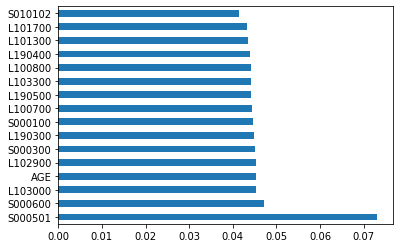

S000501    0.073117
S000600    0.047259
L103000    0.045429
AGE        0.045284
L102900    0.045272
S000300    0.045016
L190300    0.044982
S000100    0.044610
L100700    0.044511
L190500    0.044222
L103300    0.044220
L100800    0.044117
L190400    0.043960
L101300    0.043433
L101700    0.043359
S010102    0.041505
dtype: float64


<IPython.core.display.Javascript object>

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(x, y)

print(
    model.feature_importances_
)  # use inbuilt class feature_importances of tree based classifiers

# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16))

============================= Backward Elimination
========

In [41]:
import statsmodels.regression.linear_model as sm

temp = x.copy()
temp["const"] = np.ones((x.shape[0], 1))
regressor_OLS = sm.OLS(endog=y, exog=temp).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                S000502   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     3477.
Date:                Fri, 18 Oct 2019   Prob (F-statistic):               0.00
Time:                        01:02:00   Log-Likelihood:            -1.5784e+05
No. Observations:               50997   AIC:                         3.157e+05
Df Residuals:                   50968   BIC:                         3.160e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
S000501        0.3038      0.003     87.388      0.000       0.297       0.311
CLASS          5.4019      0.074     72.585      0.000       5.256       5.548
S000300       -0.0231      0.009     -2.454      0.014      -0.042      -0.005
L190400        0.6282      0.062     10.164      0.000       0.507       0.749
L190500       -0.1570      0.026     -6.077      0.000      -0.208      -0.106
L190300        0.3762      0.116      3.254      0.001       0.150       0.603
L100700        0.0890      0.025      3.595      0.000       0.040       0.137
L103000        0.0022      0.000      5.783      0.000       0.001       0.003
L103300       -0.0933      0.034     -2.743      0.006      -0.160      -0.027
L100800        0.0050      0.002      2.499      0.012       0.001       0.009
S000600        0.1104      0.002     49.482      0.000       0.106       0.115
L101700        0.0020      0.001      2.528      0.011       0.000       0.004
L100500        0.7504      0.192      3.902      0.000       0.373       1.127
L101300       -0.0023      0.001     -1.574      0.115      -0.005       0.001
S000100       -0.0108      0.004     -2.442      0.015      -0.020      -0.002
L102900        0.0046      0.001      5.394      0.000       0.003       0.006
S010102        0.0868      0.013      6.439      0.000       0.060       0.113
S010101        0.0190      0.013      1.425      0.154      -0.007       0.045
AGE            0.0309      0.003     11.093      0.000       0.025       0.036
SEX            0.4977      0.110      4.504      0.000       0.281       0.714
FIELD_38_C     0.2831      0.084      3.364      0.001       0.118       0.448
FIELD_33       0.0935      0.038      2.438      0.015       0.018       0.169
FIELD_38       0.1256      0.037      3.382      0.001       0.053       0.198
FIELD_29       0.4683      0.068      6.910      0.000       0.336       0.601
FIELD_27       0.3952      0.097      4.081      0.000       0.205       0.585
FIELD_40      -0.0342      0.020     -1.739      0.082      -0.073       0.004
FIELD_41      -0.0342      0.018     -1.938      0.053      -0.069       0.000
FIELD_28      -0.1671      0.103     -1.618      0.106      -0.369       0.035
const         18.9533      0.998     18.982      0.000      16.996      20.910
==============================================================================
Omnibus:                       55.953   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.297
Skew:                          -0.025   Prob(JB):                     1.09e-14
Kurtosis:                       3.166   Cond. No.                     1.44e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is

<IPython.core.display.Javascript object>

In [49]:
temp = temp.drop(
    columns=[
        "L103000",
        "L103300",
        "L190300",
        "FIELD_40",
        "FIELD_27",
        "FIELD_29",
        "FIELD_21",
        "FIELD_5",
        "FIELD_14",
    ]
)
regressor_OLS = sm.OLS(endog=y, exog=temp).fit()
regressor_OLS.summary()

KeyError: "['FIELD_21' 'FIELD_5' 'FIELD_14'] not found in axis"

<IPython.core.display.Javascript object>

In [49]:
temp=temp.drop(columns=['FIELD_33'])
regressor_OLS = sm.OLS(endog = y, exog = temp).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              L100800_y   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          1.851e+05
Date:                Wed, 09 Oct 2019   Prob (F-statistic):                        0.00
Time:                        21:54:41   Log-Likelihood:                         -77458.
No. Observations:               21538   AIC:                                  1.549e+05
Df Residuals:                   21524   BIC:                                  1.551e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
L100800_x      0.4959      0.007     72.088      0.000       0.482       0.509
L104600        8.5403      0.181     47.069      0.000       8.185       8.896
S000300        0.0717      0.022      3.239      0.001       0.028       0.115
SEX           -1.8595      0.163    -11.392      0.000      -2.179      -1.540
S000501        0.0194      0.008      2.494      0.013       0.004       0.035
L101700        0.0166      0.002      7.972      0.000       0.013       0.021
L190400        1.7212      0.153     11.220      0.000       1.421       2.022
S000502       -0.0279      0.010     -2.702      0.007      -0.048      -0.008
L190500       -0.6045      0.054    -11.168      0.000      -0.711      -0.498
L101300        0.0124      0.004      3.303      0.001       0.005       0.020
AGE            0.0271      0.008      3.354      0.001       0.011       0.043
FIELD_38       0.2745      0.056      4.941      0.000       0.166       0.383
FIELD_31       0.5832      0.169      3.449      0.001       0.252       0.915
FIELD_41       0.1317      0.038      3.491      0.000       0.058       0.206
==============================================================================
Omnibus:                    12859.970   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           743785.719
Skew:                           2.144   Prob(JB):                         0.00
Kurtosis:                      31.468   Cond. No.                         648.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
temp.columns

Index(['L100800_x', 'L104600', 'S000300', 'SEX', 'S000501', 'L101700',
       'L190400', 'S000502', 'L190500', 'L101300', 'AGE', 'FIELD_38',
       'FIELD_31', 'FIELD_41'],
      dtype='object')

======================== variance inflation factor 
=============

In [43]:
# this function computes vif value which help us to remove columns with redundant information ( to avoid Multicollinearity)
# Multicollinearity occurs when two or more predictors in the model are correlated and provide redundant information about the response.
# Multicollinearity was measured by variance inflation factors (VIF) and tolerance


def vifcal(inputdata, depcol):
    vifL5 = []
    import statsmodels.formula.api as sm

    xvars = inputdata.drop([depcol], axis=1)
    xvarnames = xvars.columns
    for i in range(0, xvarnames.shape[0]):
        _y = xvars[xvarnames[i]]
        _x = xvars[xvarnames.drop(xvarnames[i])]
        rsq = sm.ols(formula="_y~_x", data=xvars).fit().rsquared
        vif = round(1 / (1 - rsq), 2)
        print(i, ", ", xvarnames[i], " VIF = ", vif)
        if vif < 5:
            vifL5.append(xvarnames[i])
    return vifL5

<IPython.core.display.Javascript object>

In [44]:
newcols = vifcal(data2, "S000502")
print(newcols, len(newcols))

0 ,  S000501  VIF =  3.57
1 ,  CLASS  VIF =  3.22
2 ,  S000300  VIF =  1.63
3 ,  L190400  VIF =  16.32
4 ,  L190500  VIF =  21.19
5 ,  L190300  VIF =  5.12
6 ,  L100700  VIF =  2.07
7 ,  L103000  VIF =  1.86
8 ,  L103300  VIF =  2.53
9 ,  L100800  VIF =  1.28
10 ,  S000600  VIF =  1.1
11 ,  L101700  VIF =  1.58
12 ,  L100500  VIF =  2.24
13 ,  L101300  VIF =  1.47
14 ,  S000100  VIF =  2.65
15 ,  L102900  VIF =  1.57
16 ,  S010102  VIF =  2.73
17 ,  S010101  VIF =  2.73
18 ,  AGE  VIF =  1.44
19 ,  SEX  VIF =  5.44
20 ,  FIELD_38_C  VIF =  4.15
21 ,  FIELD_33  VIF =  1.63
22 ,  FIELD_38  VIF =  4.22
23 ,  FIELD_29  VIF =  1.05
24 ,  FIELD_27  VIF =  1.05
25 ,  FIELD_40  VIF =  1.52
26 ,  FIELD_41  VIF =  1.49
27 ,  FIELD_28  VIF =  1.03
['S000501', 'CLASS', 'S000300', 'L100700', 'L103000', 'L103300', 'L100800', 'S000600', 'L101700', 'L100500', 'L101300', 'S000100', 'L102900', 'S010102', 'S010101', 'AGE', 'FIELD_38_C', 'FIELD_33', 'FIELD_38', 'FIELD_29', 'FIELD_27', 'FIELD_40', 'FIELD_4

<IPython.core.display.Javascript object>